In [1]:
import yt
import yt.units as u
import sys

## Load the FLASH file

In [2]:
ds = yt.load("../../TDE_plot/multitidal_hdf5_plt_cnt_0100")
ds

yt : [INFO     ] 2020-12-17 16:53:39,809 Parameters: current_time              = 189076.38
yt : [INFO     ] 2020-12-17 16:53:39,811 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2020-12-17 16:53:39,827 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-12-17 16:53:39,833 Parameters: domain_right_edge         = [7.240177e+13 7.240177e+13 3.620088e+13]
yt : [INFO     ] 2020-12-17 16:53:39,840 Parameters: cosmological_simulation   = 0.0


multitidal_hdf5_plt_cnt_0100

### Domain of the simulation

In [3]:
ds.domain_width.in_units("au")

unyt_array([4.83975939, 4.83975939, 2.41987936], 'AU')

## Simple Visualization
### Projection
- A line integral through the domain

In [11]:
import matplotlib.pyplot as plt
import numpy as np

(array([  37519.,    4054.,    3117.,    4422.,    7101.,   13389.,
         125792.,  974818.,   10627.,    6761.,    3055.,    2530.,
           2253.,    2019.,    2089.,    1894.,    2150.,    2082.,
           2148.,    2190.,    2455.,    2238.,    2268.,    2324.,
           2315.,    2660.,    2846.,    3696.,    6390.,  119176.,
          37092.,   30059.,   29982.,   25058.,   16581.,   17133.,
          18553.,   14898.,   15679.,   23465.,   27500.,   26014.,
          33173.,   43346.,   43715.,   38490.,   47167.,   71228.,
          89469.,   95767.,   94850.,  106236.,  154929.,  252022.,
         304004.,  383619.,  512715.,  741786.,  808667.,  935861.,
        1120408.,  895372.,  712508.,  560061.,  482709.,  405715.,
         366755.,  283424.,  236214.,  226013.,  164581.,  135394.,
         114412.,  106347.,  116751.,  135147.,  150192.,  169752.,
         173852.,  175312.,  156757.,  122441.,  100583.,   82881.,
          68403.,   56584.,   46639.,   38231., 

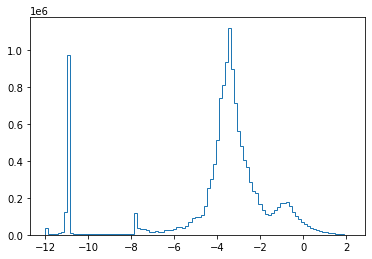

In [13]:
plt.hist(np.log10(ds.all_data()['density'].in_cgs().v), histtype='step', bins=100)

yt : [INFO     ] 2020-12-09 11:15:14,190 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 11:15:14,203 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 11:15:14,207 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 11:15:14,208 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 11:15:14,217 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



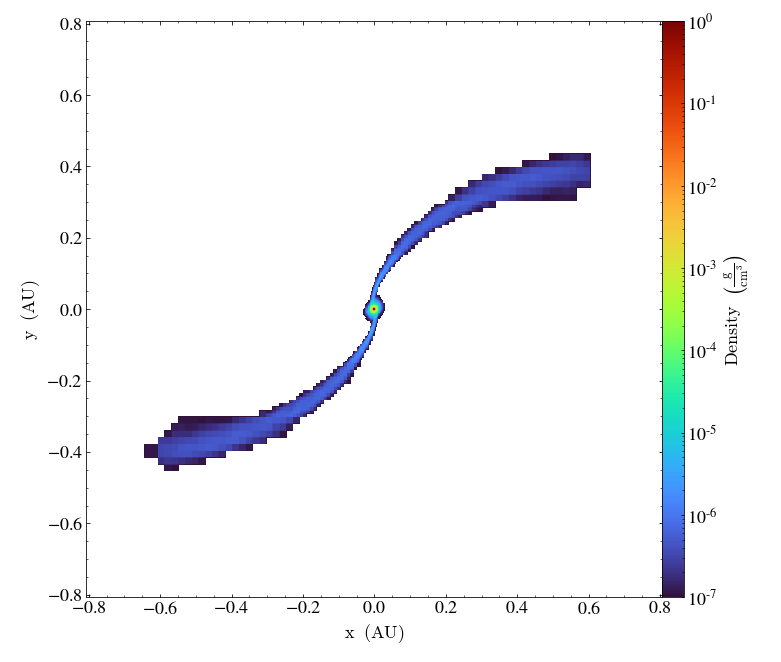

In [41]:
da = ds.all_data().cut_region('obj["density"] > 1e-7')
pp = yt.SlicePlot(ds, "z", ["density"], data_source=da)
pp.set_zlim('density', 1e-7, 1e0)
pp.set_cmap(field="density", cmap='turbo')
pp.zoom(3)

In [8]:
#pp = yt.SlicePlot(ds, "z", ["density"])
#pp.zoom(10)

## Binding Energy

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from yt.fields.api import ValidateParameter

In [ ]:
edata = np.loadtxt('../../TDE_plot/m0.8_p17_b0.6_P110_extras.dat',
                   dtype='float64')
G = u.gravitational_constant
gmpt = G * edata[6] * u.g

odata = np.loadtxt('../../TDE_plot/m0.8_p17_b0.6_P110_pruned_sinks_evol.dat',
                   dtype='float64')

if odata[0, 14] > odata[1, 14]:
    part_tag_pt = odata[0, 0]
else:
    part_tag_pt = odata[1, 0]
odata_pt = odata[np.where(odata[:, 0] == part_tag_pt)[0]]
odata_ob = odata[np.where(odata[:, 0] != part_tag_pt)[0]]

ptvec = odata_pt[:, 2:8]
obvec = odata_ob[:, 2:8]
boundvec = obvec
time = odata_pt[:, 1]
tindex = abs(time - ds.current_time.v).argmin()


def _bhbound(field, data):
    pos = np.zeros(data['x'].shape, dtype='float64')
    vel2 = pos.copy()
    for i, ax in enumerate(['x', 'y', 'z']):
        pos += (data[ax] - ptvec[tindex, i] * u.cm)**2.
    for i, ax in enumerate(['velx', 'vely', 'velz']):
        vel2 += (data[ax] - ptvec[tindex, i + 3] * u.cm / u.s)**2.
    pot = -gmpt / np.sqrt(pos) + 0.5 * vel2
    return (pot)

def _tfallback(field, data):
    pot = data['bhbound']
    return (gmpt * np.pi / np.sqrt(2) / (-pot)**(3/2))


'''def _selfbound(field, data):
    vel2 = np.zeros(data['x'].shape, dtype='float64')
    V = [data["velx"], data["vely"], data["velz"]]
    for i, ax in enumerate(['velx', 'vely', 'velz']):
        vel2 += (data[ax] - boundvec[tindex, i + 3] * u.cm / u.s)**2.

    pot = 0.5 * data['gpot'] + 0.5 * vel2
    return (pot)'''


yt.add_field(("gas", "bhbound"),
             function=_bhbound,
             units="erg/g",
             take_log=False,
             force_override=True,
             sampling_type="cell")

'''yt.add_field(("gas", "selfbound"),
             function=_selfbound,
             units="erg/g",
             take_log=False,
             force_override=True,
             sampling_type="cell")'''

yt.add_field(("gas", "tfallback"),
             function=_tfallback,
             units="day",
             take_log=False,
             force_override=True,
             sampling_type="cell")

In [48]:
ds = yt.load("../../TDE_plot/multitidal_hdf5_plt_cnt_0100")

yt : [INFO     ] 2020-12-09 11:52:45,558 Parameters: current_time              = 189076.38
yt : [INFO     ] 2020-12-09 11:52:45,560 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2020-12-09 11:52:45,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-12-09 11:52:45,564 Parameters: domain_right_edge         = [7.240177e+13 7.240177e+13 3.620088e+13]
yt : [INFO     ] 2020-12-09 11:52:45,566 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2020-12-09 11:55:52,201 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 11:55:52,203 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 11:55:52,259 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 11:55:52,262 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 11:55:52,400 Making a fixed resolution buffer of (('gas', 'bhbound')) 800 by 800



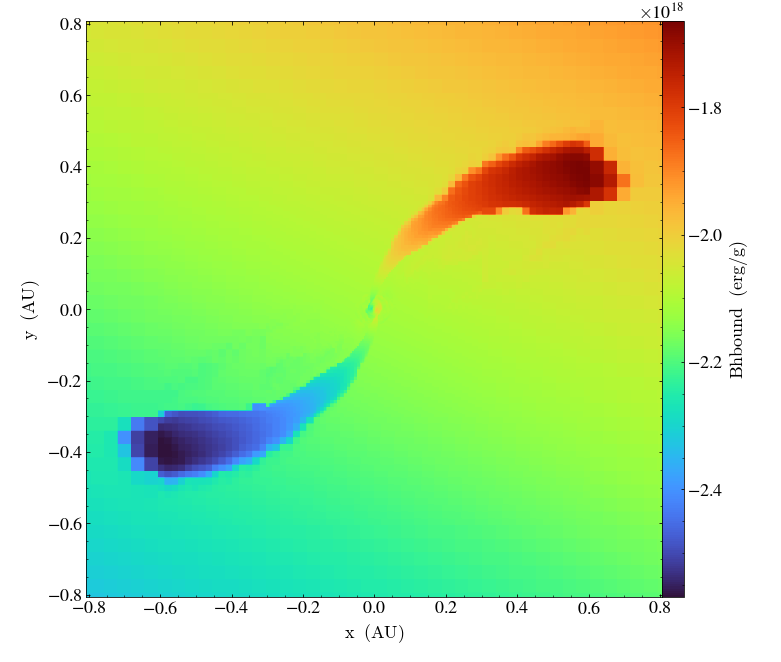

In [50]:
pp = yt.SlicePlot(ds, "z", ["bhbound"])
pp.set_cmap(field="bhbound", cmap='turbo')
pp.zoom(3)

yt : [INFO     ] 2020-12-09 15:41:36,125 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 15:41:36,151 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 15:41:36,156 xlim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 15:41:36,192 ylim = 0.000000 72401770000000.000000
yt : [INFO     ] 2020-12-09 15:41:36,254 Making a fixed resolution buffer of (('gas', 'tfallback')) 800 by 800



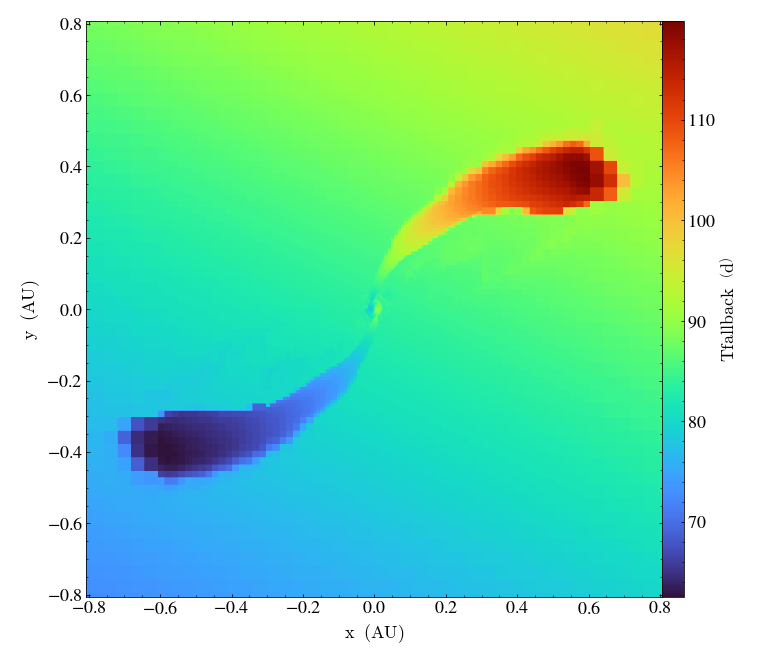

In [66]:
pp = yt.SlicePlot(ds, "z", ["tfallback"])
pp.set_cmap(field="tfallback", cmap='turbo')
pp.zoom(3)

In [ ]:
import yt

sc = yt.create_scene(ds, lens_type='perspective')

source = sc[0]

# Set transfer function properties
source.tfh.set_bounds((3e-31, 5e-27))
source.tfh.set_log(True)
source.tfh.grey_opacity = False

source.tfh.plot('transfer_function.png', profile_field='density')

sc.save('rendering.png', sigma_clip=4.0)

yt : [INFO     ] 2020-12-15 19:48:57,375 Setting default field to ('gas', 'density')
/Users/chang/opt/anaconda3/lib/python3.8/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
yt : [WARNING  ] 2020-12-15 19:49:02,669 No previously rendered image found, rendering now.
yt : [INFO     ] 2020-12-15 19:49:02,670 Rendering scene (Can take a while).
yt : [INFO     ] 2020-12-15 19:49:02,672 Creating volume
/Users/chang/opt/anaconda3/lib/python3.8/site-packages/unyt/array.py:1674: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
